Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

In [1]:
#  import sys

# # If you're on Colab:
# if 'google.colab' in sys.modules:
#     !pip install category_encoders==2.*
#     !pip install pandas-profiling==2.*


##Import data

In [2]:
import pandas as pd
import numpy as np

data1 = pd.read_csv('https://raw.githubusercontent.com/nastyalolpro/project_data/master/build_week_2/winemag-data_first150k.csv')
data2 = pd.read_csv('https://raw.githubusercontent.com/nastyalolpro/project_data/master/build_week_2/winemag-data-130k-v2.csv')
uci_red = pd.read_csv('https://raw.githubusercontent.com/nastyalolpro/project_data/master/build_week_2/winequality-red.csv', delimiter=";")
uci_white = pd.read_csv('https://raw.githubusercontent.com/nastyalolpro/project_data/master/build_week_2/winequality-white.csv', delimiter=";")

In [3]:
print(data1.shape)
data1.head()

(150930, 11)


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [4]:
print(data2.shape)
data2.head()

(129971, 14)


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


**designation**: The vineyard within the winery where the grapes that made the wine are from

**points**: The number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for 

**price**: The cost for a bottle of the wine

**province**: The province or state that the wine is from

**region_1**: The wine growing area in a province or state (ie Napa)

**region_2**: Sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this 

**variety**: The type of grapes used to make the wine (ie Pinot Noir)

In [5]:
print(uci_red.shape)
uci_red.head()

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
print(uci_white.shape)
uci_white.head()

(4898, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [7]:
uci_red['color'] = 'red'
uci_white['color'] = 'white'

uci_wine = pd.concat([uci_red, uci_white])

In [8]:
print(uci_wine.shape)
uci_wine.head()

(6497, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [9]:
#data1 = data1.drop(columns = 'Unnamed: 0')
#data2 = data2.drop(columns = ['Unnamed: 0', 'taster_name', 'taster_twitter_handle'])

##Pandas profiling

In [10]:
!pip install pandas-profiling

In [11]:
from pandas_profiling import ProfileReport
profile = ProfileReport(data1, minimal=True).to_notebook_iframe()

profile

In [12]:
profile1 = ProfileReport(data2, minimal=True).to_notebook_iframe()

profile1

In [13]:
profile_uci = ProfileReport(uci_wine, minimal=True).to_notebook_iframe()

profile1

##Choosing target

In [14]:
data1['points'].describe()

count    150930.000000
mean         87.888418
std           3.222392
min          80.000000
25%          86.000000
50%          88.000000
75%          90.000000
max         100.000000
Name: points, dtype: float64

In [15]:
data2['points'].describe()

count    129971.000000
mean         88.447138
std           3.039730
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

In [16]:
#12 - quality (score between 0 and 10)
uci_wine['quality'].describe()

count    6497.000000
mean        5.818378
std         0.873255
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64

###How is target distributed?

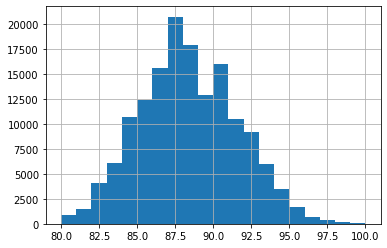

In [17]:
import matplotlib.pyplot as plt

data1['points'].hist(bins=20);

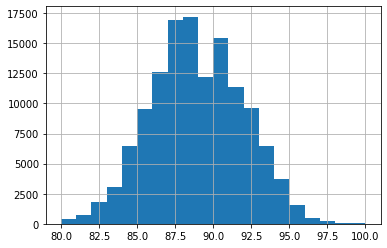

In [18]:
data2['points'].hist(bins=20);

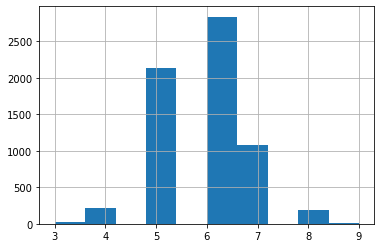

In [19]:
uci_wine['quality'].hist();

Looks like normal distribution!
Now let's translate target into categorical variable: 

###Is my problem regression or classification?

In [20]:
def wrangle_target(X):
  X = X.copy()

  quality = []
  for i in X['points']:
    if i < 87:
      quality.append('low')
    elif (86 < i)&(i < 91):
      quality.append('medium')
    else:
      quality.append('high')

  X['quality'] = quality
  return X

In [21]:
data1 = wrangle_target(data1)
data2 = wrangle_target(data2)

In [22]:
data1['quality'].value_counts(normalize = True)

medium    0.447307
low       0.339104
high      0.213589
Name: quality, dtype: float64

In [23]:
data2['quality'].value_counts(normalize = True)

medium    0.475306
low       0.265905
high      0.258788
Name: quality, dtype: float64

In [24]:
data1.sample(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery,quality
99350,99350,Italy,There's a distinctive element to this Verdicch...,NaN,86,15.0,Central Italy,Verdicchio di Matelica,NaN,Verdicchio,Capestrano,low
146975,146975,US,"Dried cherry, cedar-toast and cumin notes mark...",Splendo Blendo 1,89,80.0,California,Russian River Valley,Sonoma,Red Blend,De Loach,medium
70784,70784,US,"Silky smooth, dry and classy, this Pinot shows...",Van der Kamp Vineyard,90,45.0,California,Sonoma Mountain,Sonoma,Pinot Noir,Vergari,medium
37520,37520,Portugal,"This is a big, still young wine. Its structure...",Reserva,92,NaN,Douro,NaN,NaN,Portuguese Red,CARM,high
80835,80835,US,"Notable for its ripe, complex blackberry and c...",NaN,93,85.0,California,Napa Valley,Napa,Cabernet Sauvignon,Brion,high


Now when traget is categorical we have multi-classifictaion problem

In [25]:
uci_quality = []
for i in uci_wine['quality']:
  if i < 6:
    uci_quality.append('low')
  elif (5 < i)&(i < 7):
    uci_quality.append('medium')
  else:
    uci_quality.append('high')

In [26]:
uci_wine['quality_c'] = uci_wine['quality']

In [27]:
uci_wine['quality'] = uci_quality
uci_wine['quality'].value_counts(normalize = True)

medium    0.436509
low       0.366939
high      0.196552
Name: quality, dtype: float64

##Choosing evaluation metric(s)

In [28]:
data1['quality'].value_counts(normalize = True).max()

0.4473066984694892

In [29]:
data2['quality'].value_counts(normalize = True).max()

0.47530602980664916

In [31]:
uci_wine['quality'].value_counts(normalize = True).max()

0.43650915807295676

For this problem I'll focus on keeping precision high to make sure that none of the low quality wines are misclassified to have high quality. 

## Choose which observations you will use to train, validate, and test your model

In [35]:
from sklearn.model_selection import train_test_split

data = pd.concat([data1, data2], join = 'outer')

train, test = train_test_split(data, train_size = .8, test_size = .2, )

In [36]:
train.shape, test.shape

((224720, 15), (56181, 15))

In [38]:
target = 'quality'

X_train = train.drop(columns = target)
y_train = train[target]
X_test = test.drop(columns = target)
y_test = test[target]

In [39]:
train_uci, test_uci = train_test_split(uci_wine, train_size = .8, test_size = .2)
train_uci.shape, test_uci.shape

((5197, 14), (1300, 14))

In [40]:
target = 'quality'

X_train_uci = train_uci.drop(columns = target)
y_train_uci = train_uci[target]
X_test_uci = test_uci.drop(columns = target)
y_test_uci = test_uci[target]